In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import IPython
IPython.display.Audio("ibeep.mp3",autoplay=True)

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
from sindy_functions import *
from systems import *

In [ ]:
#lorenz

In [5]:
x0=[0,1,20]

dt=1e-2
tstamps=np.arange(0,10,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

In [ ]:
plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Lorenz Simulation Data')
plt.axis('off')
plt.show()

In [6]:
deg=3
thres=0.1
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['x','y','z'],deg)
dispmymod(mc,['x\'','y\'','z\''],names)
corr=np.nan_to_num(mc/mc)
#corr=np.copy(mc)
#corr

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [7]:
#x, x' normalisation - noise free

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([20,26,47])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
#np.random.seed(1)
nlevel=0.02
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
#nlevel=0.002
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
#nlevel=0.002
#nSol=np.random.normal(nSol,nlevel/2)
nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([20,26,47])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

initial midpoint: [0 0 0]
initial variable normalisation constants (division): [20 26 47]
midpoint: [0 0 0]
variable normalisation constants (division): [20 26 47]


In [17]:
STSRATE=[]
optthress=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
nlevels=np.linspace(0,0.05,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=post_SINDy(w,rtr,rtqtb,thress[ithres],reg=1e-16)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [20]:
STRSRATE=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
laps=np.arange(0.02,1,0.1)
nlevels=np.linspace(0,0.05,11)

for a in tnrange(100):
    strsrate=[]
    for inlevel in tnrange(len(nlevels),leave=False):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,thress[ithres],reg=1e-6,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        strsrate.append(success)
    
    STRSRATE.append(strsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  if __name__ == "__main__":


  0%|          | 0/11 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

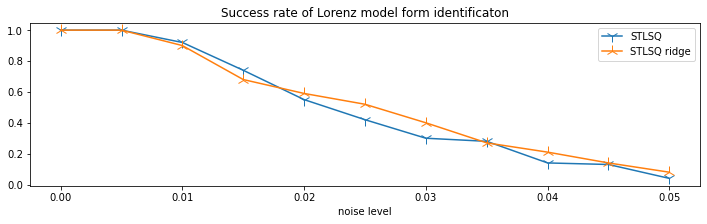

In [21]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Lorenz model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(STRSRATE),axis=0),'2-',markersize=12,label='STLSQ ridge')
plt.legend()
plt.show()

In [22]:
ESRATE=[]

optthres=np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:585: RuntimeWarning: invalid value encountered in true_divide
  inc.append(np.nan_to_num(np.abs(mc/mc)))
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [24]:
CVSRATE=[]

ptfs=np.geomspace(1e-3,1,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:1120: RuntimeWarning: invalid value encountered in true_divide
  modelchange=np.any(np.nan_to_num(cterms/cterms)!=np.nan_to_num(nterms/nterms))
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [26]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-1,1e-1,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=post_re_SINDy(w,rtr,rtqtb,copy.deepcopy(mc0),thress[ithres],reg=1e-16)
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


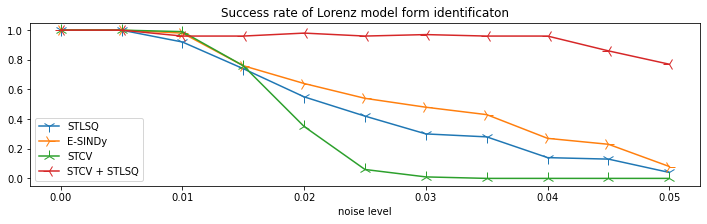

In [27]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Lorenz model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [30]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[1.  , 1.  , 0.92, 0.74, 0.55, 0.42, 0.3 , 0.28, 0.14, 0.13, 0.04],
       [1.  , 1.  , 0.98, 0.76, 0.64, 0.54, 0.48, 0.43, 0.27, 0.23, 0.08],
       [1.  , 1.  , 0.99, 0.76, 0.35, 0.06, 0.01, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.96, 0.96, 0.98, 0.96, 0.97, 0.96, 0.96, 0.86, 0.77]])

In [ ]:
#np.savetxt('lorenz.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [28]:
np.loadtxt('lorenz.stcv')

array([[1.  , 1.  , 0.93, 0.77, 0.61, 0.45, 0.36, 0.31, 0.13, 0.06, 0.03],
       [1.  , 1.  , 0.86, 0.74, 0.65, 0.61, 0.41, 0.36, 0.28, 0.08, 0.06],
       [1.  , 1.  , 0.97, 0.71, 0.36, 0.04, 0.04, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.95, 0.96, 0.97, 0.94, 0.97, 0.96, 0.94, 0.91, 0.7 ]])

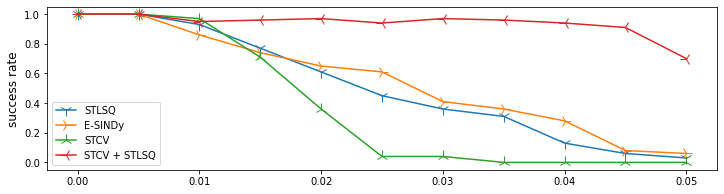

In [29]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
#plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('lorenz.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('lorenz.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('lorenz.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('lorenz.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [31]:
#lorenz - normalised

In [32]:
STSRATE=[]
optthress=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
nlevels=np.linspace(0,0.01,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,normalise='auto')

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=post_SINDy(w,rtr,rtqtb,thress[ithres],reg=1e-16)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  import sys


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide


In [33]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.9)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,optthres[inlevel],50,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [34]:
CVSRATE=[]

ptfs=np.geomspace(0.001,3,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  """


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


In [35]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([20,26,47])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,normalise='auto')

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-1,1e-1,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=post_re_SINDy(w,rtr,rtqtb,copy.deepcopy(mc0),thress[ithres],reg=1e-16)
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


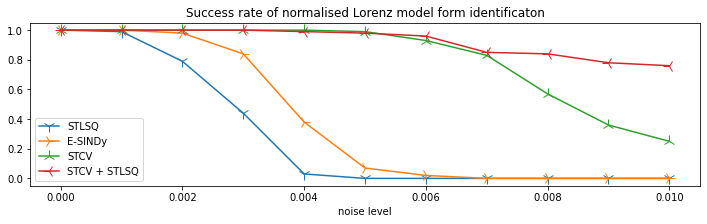

In [36]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Lorenz model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [39]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

array([[1.  , 0.99, 0.79, 0.44, 0.03, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.98, 0.84, 0.38, 0.07, 0.02, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.99, 0.93, 0.83, 0.57, 0.36, 0.25],
       [1.  , 1.  , 1.  , 1.  , 0.99, 0.98, 0.96, 0.85, 0.84, 0.78, 0.76]])

In [37]:
#np.savetxt('lorenznorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [40]:
np.loadtxt('lorenznorm.stcv')

array([[1.  , 0.98, 0.8 , 0.46, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 0.82, 0.41, 0.05, 0.01, 0.01, 0.01, 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 0.98, 0.93, 0.85, 0.63, 0.48, 0.24],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.97, 0.84, 0.89, 0.8 , 0.78]])

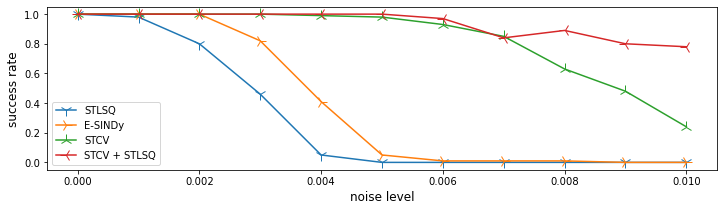

In [41]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('lorenznorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('lorenznorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('lorenznorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('lorenznorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [42]:
#Rossler

In [43]:
x0=[14,8,0]

dt=1e-3
tstamps=np.arange(0,10,dt)

Sol=sc.integrate.odeint(rossler,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

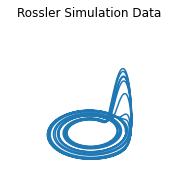

In [44]:
plt.figure(figsize=(4,3))
ax=plt.axes(projection='3d')
ax.plot3D(Sol[0], Sol[1], Sol[2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Rossler Simulation Data')
plt.axis('off')
plt.show()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


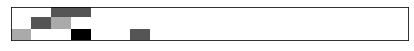

In [45]:
deg=3
thres=0.01
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['x','y','z'],deg)
dispmymod(mc,['x\'','y\'','z\''],names)
corr=np.nan_to_num(mc/mc)
#corr=np.copy(mc)
#corr

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [46]:
#x, x' normalisation - noise free

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([22.15813269, 21.15304412, 36.49918065])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

#noise addition
#np.random.seed(1)
nlevel=0.01
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
#nlevel=0.002
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
#nlevel=0.002
#nSol=np.random.normal(nSol,nlevel/2)
nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

#x, x' normalisation - with noise

midpoint=np.array([0,0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([22.15813269, 21.15304412, 36.49918065])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

initial midpoint: [0 0 0]
initial variable normalisation constants (division): [22.15813269 21.15304412 36.49918065]
midpoint: [0 0 0]
variable normalisation constants (division): [22.15813269 21.15304412 36.49918065]


In [ ]:
STSRATE=[]
optthress=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
nlevels=np.linspace(0,0.02,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=post_SINDy(w,rtr,rtqtb,thress[ithres],reg=1e-16)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.3)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.08,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-1,1e-1,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=post_re_SINDy(w,rtr,rtqtb,copy.deepcopy(mc0),thress[ithres],reg=1e-16)
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Rossler model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('rossler.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [47]:
np.loadtxt('rossler.stcv')

array([[1.  , 1.  , 0.07, 0.42, 0.88, 0.77, 0.48, 0.1 , 0.02, 0.  , 0.  ],
       [1.  , 1.  , 0.12, 0.18, 0.46, 0.33, 0.28, 0.  , 0.  , 0.02, 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.86, 0.  , 0.  , 0.14, 0.3 , 0.34, 0.12, 0.  , 0.  , 0.  ]])

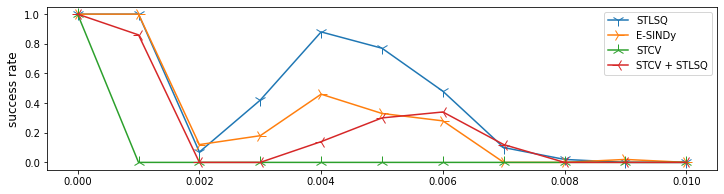

In [48]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
#plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('rossler.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('rossler.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('rossler.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('rossler.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [49]:
#rossler - normalised

In [ ]:
STSRATE=[]
optthress=[]

thress=np.linspace(0,0.025,10)
thress[0]=0.001
nlevels=np.linspace(0,0.001,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,normalise='auto')

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=post_SINDy(w,rtr,rtqtb,thress[ithres],reg=1e-16)
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.1)

for a in tnrange(2):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.1,1.2,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
        nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([22.15813269, 21.15304412, 36.49918065])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T
        
        w,rtr,rtqtb=SINDy_prec(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,normalise='auto')

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-5,1e-5,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=post_re_SINDy(w,rtr,rtqtb,copy.deepcopy(mc0),thress[ithres],reg=1e-16)
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Rossler model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('rosslernorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [50]:
np.loadtxt('rosslernorm.stcv')

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , 1.  , 1.  , 0.62, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 1.  , 0.65, 0.  , 0.  , 0.  , 0.  , 0.  ]])

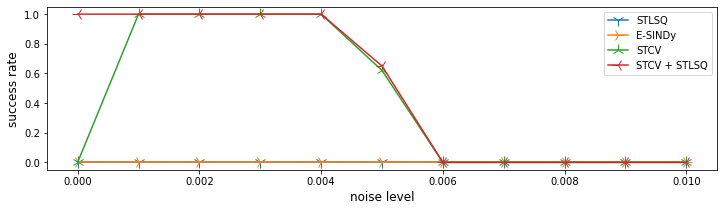

In [51]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('rosslernorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('rosslernorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('rosslernorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('rosslernorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [52]:
#van der pol

In [53]:
x0=[2,0]

dt=0.01
N=1
Tf=30
tstamps=np.arange(0,Tf,dt)

sol=sc.integrate.solve_ivp(pol_,[0,Tf],x0,t_eval=tstamps,method='LSODA').y
Sol=sol
Soldt=np.gradient(sol[:,:],dt,axis=1)

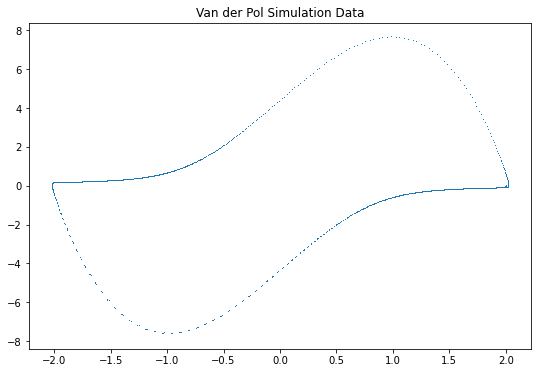

In [54]:
plt.figure(figsize=(9,6))
plt.plot(Sol[0],Sol[1],',')
plt.title('Van der Pol Simulation Data')
plt.show()

#plt.figure(figsize=(12,4))
#plt.plot(tstamps,Sol[0])
#plt.plot(tstamps,Sol[1])
#plt.show()

In [55]:
deg=3
thres=0.1
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corr=np.nan_to_num(mc/mc)
#corr=np.copy(mc)
#corr

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [56]:
#x, x' normalisation - noise free

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([2,8])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    nSolnfdt=np.hstack((nSolnfdt,np.gradient(nSolnf[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

#noise addition
#np.random.seed(1)
nlevel=0.08
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
#nlevel=0.02
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
uSoldt=np.gradient(uSol[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    uSoldt=np.hstack((uSoldt,np.gradient(uSol[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

#x, x' normalisation - with noise

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([2,8])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    nSoldt=np.hstack((nSoldt,np.gradient(nSol[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

initial midpoint: [0 0]
initial variable normalisation constants (division): [2 8]
midpoint: [0 0]
variable normalisation constants (division): [2 8]


In [ ]:
STSRATE=[]
optthress=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
nlevels=np.linspace(0.0,0.10,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,thress[ithres],reg=1e-16,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.2,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-1,1e-1,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=re_SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,copy.deepcopy(mc0),thress[ithres],reg=1e-16,normalise='auto')
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Van der Pol model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('pol.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [57]:
np.loadtxt('pol.stcv')

array([[1.  , 1.  , 1.  , 1.  , 1.  , 0.83, 0.48, 0.33, 0.45, 0.56, 0.37],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 0.8 , 0.61, 0.55, 0.46, 0.4 ],
       [1.  , 1.  , 1.  , 1.  , 0.71, 0.43, 0.09, 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.99, 0.84, 0.41, 0.28, 0.44, 0.46, 0.51]])

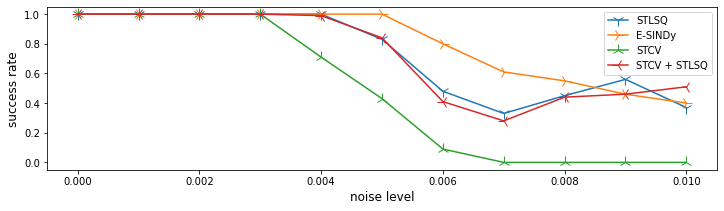

In [58]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('pol.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('pol.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('pol.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('pol.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [59]:
#van der pol - normalised

In [ ]:
STSRATE=[]
optthress=[]

thress=np.linspace(0,0.225,10)
thress[0]=0.01
nlevels=np.linspace(0.0,0.1,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,thress[ithres],reg=1e-16,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.1)

for a in tnrange(20):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.2,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([2,8])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-1,1e-1,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=re_SINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,copy.deepcopy(mc0),thress[ithres],reg=1e-16,normalise='auto')
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Van der Pol model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('polnorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [60]:
np.loadtxt('polnorm.stcv')

array([[1.  , 0.56, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 1.  , 1.  , 0.7 , 0.46, 0.07, 0.01, 0.  , 0.  , 0.  ],
       [1.  , 1.  , 1.  , 1.  , 0.77, 0.45, 0.09, 0.  , 0.  , 0.  , 0.  ]])

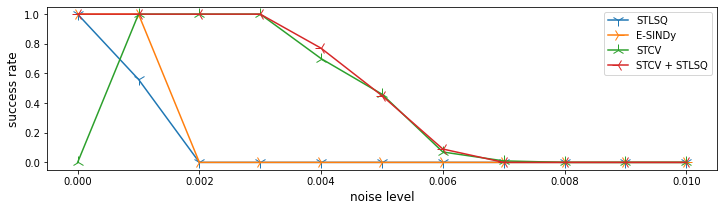

In [61]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('polnorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('polnorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('polnorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('polnorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [62]:
#duffing

In [63]:
x0=[1,0]

dt=0.01
N=1
Tf=10
tstamps=np.arange(0,Tf,dt)

sol=sc.integrate.solve_ivp(duf_,[0,Tf],x0,t_eval=tstamps,method='LSODA').y
Sol=sol
Soldt=np.gradient(sol[:,:],dt,axis=1)

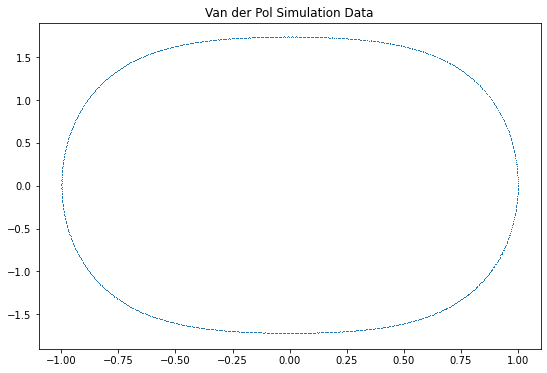

In [64]:
plt.figure(figsize=(9,6))
plt.plot(Sol[0],Sol[1],',')
plt.title('Van der Pol Simulation Data')
plt.show()

#plt.figure(figsize=(12,4))
#plt.plot(tstamps,Sol[0])
#plt.plot(tstamps,Sol[1])
#plt.show()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


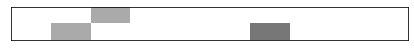

In [65]:
deg=3
thres=0.1
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise='auto')
names=polypool_names(['x','y'],deg)
dispmymod(mc,['x\'','y\''],names)
corr=np.nan_to_num(mc/mc)
#corr=np.copy(mc)
#corr

plt.figure(figsize=(6,1))
plt.imshow(np.log10(np.abs(mc.T)),cmap='gray_r',aspect='auto',vmin=-1,vmax=2)
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

In [66]:
#x, x' normalisation - noise free

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
print('initial midpoint:',midpoint)
Solm=Sol-np.reshape(midpoint,(-1,1))

nc=np.abs(Solm.T).max(axis=0)
nc=np.array([1,1.73])
print('initial variable normalisation constants (division):',nc)
nSol=Solm.T/nc
nSol=nSol.T
nSolnf=np.copy(nSol)
nSolnfdt=np.gradient(nSolnf[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    nSolnfdt=np.hstack((nSolnfdt,np.gradient(nSolnf[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

#noise addition
#np.random.seed(1)
nlevel=0.05
#nSol=np.random.normal(nSol,nlevel/2)
nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
#nlevel=0.02
#nSol=np.random.normal(nSol,nlevel/2)
nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[0]))

#implied noisy measurements - unnormalised
uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
uSoldt=np.gradient(uSol[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    uSoldt=np.hstack((uSoldt,np.gradient(uSol[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

#x, x' normalisation - with noise

midpoint=np.array([0,0])
#midpoint=np.average(Sol,axis=1)
#midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
print('midpoint:',midpoint)
uSolm=uSol-np.reshape(midpoint,(-1,1))

nc=np.abs(uSolm.T).max(axis=0)
nc=np.array([1,1.73])
print('variable normalisation constants (division):',nc)
nSol=uSolm.T/nc
nSol=nSol.T
nSoldt=np.gradient(nSol[:,:int(Tf/N/dt)],dt,axis=1)
for i in range(N-1):
    nSoldt=np.hstack((nSoldt,np.gradient(nSol[:,(i+1)*int(Tf/N/dt):(i+2)*int(Tf/N/dt)],dt,axis=1)))

initial midpoint: [0 0]
initial variable normalisation constants (division): [1.   1.73]
midpoint: [0 0]
variable normalisation constants (division): [1.   1.73]


In [ ]:
STSRATE=[]
optthress=[]

thress=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
nlevels=np.linspace(0.0,0.10,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(uSol[:,:].T,deg)),uSoldt[:,:].T,thress[ithres],reg=1e-16,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.2,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,0.01,1e2,1e2,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=re_SINDy(polypool(uSol[:,:].T,deg),uSoldt[:,:].T,copy.deepcopy(mc0),thress[ithres],reg=1e-16,normalise='auto')
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of Duffing oscillator form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('duff.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [67]:
np.loadtxt('duff.stcv')

array([[1.  , 1.  , 1.  , 0.85, 0.58, 0.41, 0.38, 0.32, 0.29, 0.2 , 0.21],
       [1.  , 1.  , 0.99, 0.71, 0.51, 0.47, 0.39, 0.33, 0.29, 0.31, 0.21],
       [1.  , 1.  , 0.95, 0.58, 0.23, 0.27, 0.16, 0.12, 0.09, 0.11, 0.06],
       [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

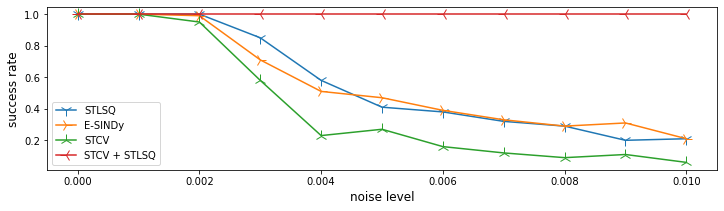

In [68]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('duff.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('duff.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('duff.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('duff.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()

In [69]:
#duffing - normalised

In [ ]:
STSRATE=[]
optthress=[]

thress=np.linspace(0,0.55,10)
thress[0]=0.01
nlevels=np.linspace(0.0,0.1,11)

for a in tnrange(100):
    stsrate=[]
    optthres=np.nan*np.ones_like(nlevels)
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for ithres in range(len(thress)):
            if not success:
                mc=SINDy(np.nan_to_num(polypool(nSol[:,:].T,deg)),nSoldt[:,:].T,thress[ithres],reg=1e-16,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
                    optthres[inlevel]=thress[ithres]
        stsrate.append(success)
    optthress.append(optthres)
    
    STSRATE.append(stsrate)

In [ ]:
ESRATE=[]

optthres=np.nan_to_num(np.nansum(optthress,axis=0)/np.nansum(np.abs(np.array(optthress)/np.array(optthress)),axis=0), nan=0.5)

for a in tnrange(100):
    esrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for incp in np.arange(0.1,1,0.1):
            if not success:
                mc=ESINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,optthres[inlevel],100,0.632,1e-16,incp,normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        esrate.append(success)
    
    ESRATE.append(esrate)

In [ ]:
CVSRATE=[]

ptfs=np.linspace(0.001,0.2,10)

for a in tnrange(100):
    cvsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e-16,1e-16,0,10,ptf=ptfs[iptf],normalise='auto')
                if np.all(np.nan_to_num(mc/mc)==corr):
                    success=True
        cvsrate.append(success)
    
    CVSRATE.append(cvsrate)

In [ ]:
CVSTSRATE=[]

for a in tnrange(100):
    cvstsrate=[]
    for inlevel in range(len(nlevels)):
        midpoint=np.array([0,0])
        Solm=Sol-np.reshape(midpoint,(-1,1))

        nc=np.abs(Solm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=Solm.T/nc
        nSol=nSol.T
        nSolnf=np.copy(nSol)
        nSolnfdt=np.gradient(nSolnf.T[:,:],dt,axis=0).T

        nlevel=nlevels[inlevel]
        nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
        nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))

        uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))
        uSoldt=np.gradient(uSol.T[:,:],dt,axis=0).T

        midpoint=np.array([0,0])
        uSolm=uSol-np.reshape(midpoint,(-1,1))

        nc=np.abs(uSolm.T).max(axis=0)
        nc=np.array([1,1.73])
        nSol=uSolm.T/nc
        nSol=nSol.T
        nSoldt=np.gradient(nSol.T[:,:],dt,axis=0).T

        success=False
        for iptf in range(len(ptfs)):
            if not success:
                mc0=SINDyCV_t(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,0.01,1e2,1e2,0,10,ptf=ptfs[iptf],normalise='auto')
                for ithres in range(len(thress)):
                    mc=re_SINDy(polypool(nSol[:,:].T,deg),nSoldt[:,:].T,copy.deepcopy(mc0),thress[ithres],reg=1e-16,normalise='auto')
                    if np.all(np.nan_to_num(mc/mc)==corr):
                        success=True
        cvstsrate.append(success)
    
    CVSTSRATE.append(cvstsrate)

In [ ]:
plt.figure(figsize=(12,3))
plt.title('Success rate of normalised Duffing oscillator model form identificaton')
plt.xlabel('noise level')
plt.plot(nlevels,np.average(np.array(STSRATE),axis=0),'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.average(np.array(ESRATE),axis=0),'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.average(np.array(CVSRATE),axis=0),'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.average(np.array(CVSTSRATE),axis=0),'3-',markersize=12,label='STCV + STLSQ')
plt.legend()
plt.show()

In [ ]:
np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0)))

In [ ]:
#np.savetxt('duffnorm.stcv',np.vstack((np.average(np.array(STSRATE),axis=0),np.average(np.array(ESRATE),axis=0),np.average(np.array(CVSRATE),axis=0),np.average(np.array(CVSTSRATE),axis=0))))

In [70]:
np.loadtxt('duffnorm.stcv')

array([[1.  , 1.  , 0.48, 0.14, 0.07, 0.02, 0.04, 0.  , 0.01, 0.01, 0.  ],
       [1.  , 1.  , 0.87, 0.43, 0.3 , 0.23, 0.13, 0.07, 0.04, 0.05, 0.04],
       [1.  , 1.  , 0.88, 0.5 , 0.34, 0.19, 0.15, 0.11, 0.09, 0.12, 0.1 ],
       [1.  , 1.  , 0.98, 0.75, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]])

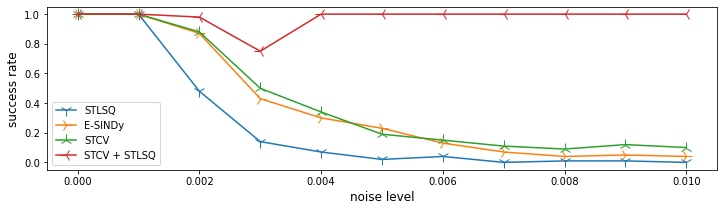

In [71]:
plt.figure(figsize=(12,3))
plt.ylabel('success rate',fontsize=12)
plt.xlabel('noise level',fontsize=12)
plt.plot(nlevels,np.loadtxt('duffnorm.stcv')[0],'1-',markersize=12,label='STLSQ')
plt.plot(nlevels,np.loadtxt('duffnorm.stcv')[1],'4-',markersize=12,label='E-SINDy')
plt.plot(nlevels,np.loadtxt('duffnorm.stcv')[2],'2-',markersize=12,label='STCV')
plt.plot(nlevels,np.loadtxt('duffnorm.stcv')[3],'3-',markersize=12,label='STCV + STLSQ')
#plt.xticks(nlevels[::2],['']*6)
plt.legend()
plt.show()